In [1]:
# %% imports
import sys, os, math, time, copy, random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import scipy.linalg

# 🏗  local modules from *your* codebase
sys.path.append("../utility")                 # adjust if notebook sits elsewhere
from dataset import FrankaDataCollector
from network import KoopmanNet
from dataset import KoopmanDatasetCollector

# notebook plotting style
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['axes.grid'] = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pybullet build time: Jan 29 2025 23:16:28


In [2]:
# Load collector for normalized Franka dataset (same config as training)
collector = KoopmanDatasetCollector(env_name="Franka", normalize=True)
train_data = collector.train_data
u_dim = collector.u_dim
state_dim = collector.state_dim

# Extract normalization stats
action_train_mean = np.mean(train_data[..., :u_dim], axis=(0, 1))
action_train_std = np.std(train_data[..., :u_dim], axis=(0, 1))
state_train_mean = np.mean(train_data[..., u_dim:], axis=(0, 1))
state_train_std = np.std(train_data[..., u_dim:], axis=(0, 1))

# For safety
action_train_std = np.maximum(action_train_std, 1e-8)
state_train_std = np.maximum(state_train_std, 1e-8)

# Normalization function
def normalize_state_input(x, mean=state_train_mean, std=state_train_std):
    return (x - mean) / std

b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
panda_link0b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
panda_link1b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
panda_link2b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfIm

In [3]:
# %% load checkpoint
# point to the .pth that train.py saved (edit the path if required)
CKPT_PATH = "../log/May_3_residual/best_models/20250502_195925_model_Franka.pth"

ckpt = torch.load(CKPT_PATH, map_location=device)
layers = ckpt["layer"]
state_dim = layers[0]                 # first element is input dim
encode_dim = layers[-1]
u_dim = 7                             # Franka actions
Nkoop = state_dim + encode_dim

net = KoopmanNet(layers, Nkoop, u_dim, use_residual=False).to(device).double()
net.load_state_dict(ckpt["model"])
net.eval()

A_d = net.lA.weight.detach().cpu().numpy()
B_d = net.lB.weight.detach().cpu().numpy()
print("Loaded Koopman model:", CKPT_PATH)
print("A_d shape:", A_d.shape, "  B_d shape:", B_d.shape)
print("max |eig(A_d)| =", np.abs(np.linalg.eigvals(A_d)).max())


Loaded Koopman model: ../log/May_3_residual/best_models/20250502_195925_model_Franka.pth
A_d shape: (81, 81)   B_d shape: (81, 7)
max |eig(A_d)| = 1.0002841181028104


In [4]:
# %% discrete-time LQR gain
def dlqr(A, B, Q, R):
    """Solve the discrete-time algebraic Riccati eqn for K"""
    X = scipy.linalg.solve_discrete_are(A, B, Q, R)
    K = np.linalg.inv(B.T @ X @ B + R) @ (B.T @ X @ A)
    return K

# Penalise first 10 physical states heavily, small control penalty
Q = np.zeros((Nkoop, Nkoop))
Q[:10,:10] = np.eye(10)
R = 0.1*np.eye(u_dim)

K_lqr = dlqr(A_d, B_d, Q, R)
print("LQR gain shape:", K_lqr.shape)


LQR gain shape: (7, 81)


In [5]:
# %% environment  (reuse your collector as a simulator wrapper)
env = FrankaDataCollector(render=False)   # headless; set True to watch
accuracy_ik = 1e-6                        # IK tolerance

def accurate_ik(target_xyz, max_iter=10000):
    """Inverse kinematics (wraps PyBullet’s IK until <accuracy)."""
    for _ in range(max_iter):
        joints = torch.tensor(
            env.get_ik(target_xyz), dtype=torch.float64
        )
        for j, q in enumerate(joints):
            # temporarily place joints to compute err
            import pybullet as pb
            pb.resetJointState(env.robot, j, q.item())
        link_pos = env.get_state()[:3]
        if np.linalg.norm(link_pos - target_xyz) < accuracy_ik:
            return joints.numpy()
    raise RuntimeError("IK did not converge")

def obs_franka(state):
    """Observation mapping used in training (x,y,z + 14D joint/vel)."""
    return np.concatenate((state[:3], state[7:]), axis=0)


b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
panda_link0b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
panda_link1b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
panda_link2b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfIm

In [6]:
# helper: convert 21-D raw state -> 17-D observable state
def obs17(full_state_np):
    # xyz (0:3)       +  joints (7:14)  + velocities (14:21)
    return np.concatenate((full_state_np[:3], full_state_np[7:]), axis=0)

In [17]:
# %% helpers for Ψ(x) and Ψ(x,u)
def psi_state(state_np):
    if state_np.shape[0] == 21:
        state_np = np.concatenate([state_np[:3], state_np[7:]])  # to 17-D observed

    state_np = normalize_state_input(state_np)  # normalize here
    s = torch.from_numpy(state_np).double().to(device)
    with torch.no_grad():
        return net.encode(s)[None, ...].cpu().numpy()[0]

def psi_state_u(state_np, u_np):
    psi = np.zeros((Nkoop + u_dim,))
    psi[:Nkoop] = psi_state(state_np)
    psi[Nkoop:] = u_np
    return psi

In [18]:
# %% generate figure-8 waypoints & convert to desired joint states
T_sec = 6.0          # total duration (real seconds)
dt_sim = env.dt      # env sample time = 10*0.002 = 0.02
T_steps = int(T_sec / dt_sim)
t = np.linspace(0, T_sec, T_steps+1)

a = 0.3
x_d = 0.3*np.ones_like(t)
y_d = a*np.cos(2*np.pi*t/T_sec) / (1 + np.sin(2*np.pi*t/T_sec)**2)
z_d = 0.59 + 2*a*np.sin(2*np.pi*t/T_sec)*np.cos(2*np.pi*t/T_sec)/(1+np.sin(2*np.pi*t/T_sec)**2)

# inverse kinematics to joint space
desired_states = np.empty((T_steps+1, env.Nstates))
for k in range(T_steps+1):
    joints = accurate_ik([x_d[k], y_d[k], z_d[k]])
    desired_states[k, :3] = [x_d[k], y_d[k], z_d[k]]
    desired_states[k, 3:10] = joints         # joint angles
    desired_states[k, 10:] = 0.0             # joint velocities
print("Generated desired trajectory with", desired_states.shape[0], "points")


Generated desired trajectory with 301 points


In [19]:
# %% simulate
state = env.reset()
# initialise robot near the first desired pose
for j,q in enumerate(desired_states[0,3:10]): 
    import pybullet as pb
    pb.resetJointState(env.robot, j, q)

def step_control(state_np, goal_state_np):
    psi_x = psi_state(state_np)
    psi_goal = psi_state(goal_state_np)
    u_ctrl = -K_lqr @ (psi_x - psi_goal)
    return np.clip(u_ctrl, -env.sat_val, env.sat_val)

state_dim_full = state.shape[0]        # 21
state_log = np.zeros((T_steps+1, state_dim_full))
ctrl_log  = np.zeros((T_steps, u_dim))

state_log[0] = state
for k in range(T_steps):
    u_k = step_control(state, desired_states[k+1])
    ctrl_log[k] = u_k
    state = env.step(u_k)
    state_log[k+1] = state

print("Simulation finished.")


Simulation finished.


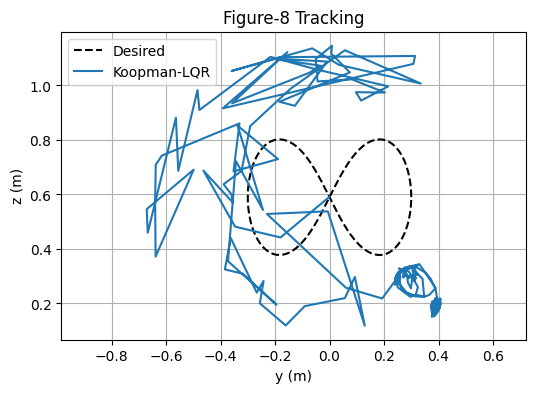

RMS EE error (xyz): 0.4678 m


In [20]:
# %% plots
plt.figure()
plt.plot(desired_states[:,1], desired_states[:,2], 'k--', label='Desired')
plt.plot(state_log[:,1], state_log[:,2], label='Koopman-LQR')
plt.axis('equal'); plt.xlabel('y (m)'); plt.ylabel('z (m)')
plt.legend(); plt.title('Figure-8 Tracking'); plt.show()

# RMS error in xyz
err = desired_states[:,:3] - state_log[:,:3]
rms = np.sqrt((err**2).mean())
print("RMS EE error (xyz): %.4f m" % rms)


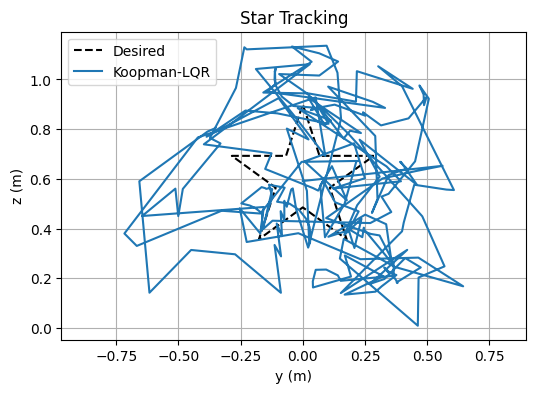

Star RMS EE error: 0.3324 m


In [21]:
# %% star path generator (same idea as the original notebook)
def star_points(center, radius):
    pts = np.zeros((11,2))
    theta0 = np.pi/10.0
    R_inner = radius*np.tan(2*theta0)*np.cos(theta0) - radius*np.sin(theta0)
    for i in range(5):
        theta = 2*np.pi/5*(i+0.25)
        beta  = 2*np.pi/5*(i+0.75)
        pts[2*i]   = [np.cos(theta)*radius + center[0],
                      np.sin(theta)*radius + center[1]]
        pts[2*i+1] = [np.cos(beta)*R_inner + center[0],
                      np.sin(beta)*R_inner + center[1]]
    pts[-1] = pts[0]
    return pts

center = np.array([0.0, 0.6])
radius = 0.3
T_sec_star = 6.0
T_steps_star = int(T_sec_star/dt_sim)
t_star = np.linspace(0, T_sec_star, T_steps_star+1)

# linear interpolation along star polygon
star_xy = star_points(center, radius)
seg_len = (T_steps_star) // 10
y_star = np.zeros_like(t_star)
z_star = np.zeros_like(t_star)
for i in range(10):
    p0, p1 = star_xy[i], star_xy[i+1]
    for s in range(seg_len):
        idx = i*seg_len + s
        alpha = s/seg_len
        y_star[idx] = (1-alpha)*p0[0] + alpha*p1[0]
        z_star[idx] = (1-alpha)*p0[1] + alpha*p1[1]
y_star[-1], z_star[-1] = star_xy[-1]

x_star = 0.3*np.ones_like(y_star)

desired_star = np.empty((T_steps_star+1, env.Nstates))
for k in range(T_steps_star+1):
    joints = accurate_ik([x_star[k], y_star[k], z_star[k]])
    desired_star[k,:3] = [x_star[k], y_star[k], z_star[k]]
    desired_star[k,3:10] = joints
    desired_star[k,10:] = 0.0

# simulate with same controller
state = env.reset()
for j,q in enumerate(desired_star[0,3:10]):
    import pybullet as pb
    pb.resetJointState(env.robot, j, q)

state_dim_full = state.shape[0]        # 21
state_log2 = np.zeros((T_steps_star+1, state_dim_full))
ctrl_log2  = np.zeros((T_steps_star, u_dim))

state_log2[0] = state
for k in range(T_steps_star):
    u_k = step_control(state, desired_star[k+1])
    ctrl_log2[k] = u_k
    state = env.step(u_k)
    state_log2[k+1] = state

plt.figure()
plt.plot(desired_star[:,1], desired_star[:,2], 'k--', label='Desired')
plt.plot(state_log2[:,1], state_log2[:,2], label='Koopman-LQR')
plt.axis('equal'); plt.xlabel('y (m)'); plt.ylabel('z (m)')
plt.legend(); plt.title('Star Tracking'); plt.show()

err2 = desired_star[:,:3] - state_log2[:,:3]
print("Star RMS EE error: %.4f m" % np.sqrt((err2**2).mean()))
